**ENGY-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Neutron Diffusion on a Spherical Domain
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
  \newcommand{\normal}{\boldsymbol{n}}
  \newcommand{\flux}{\boldsymbol{q}}
  \newcommand{\ihat}{\hat{\boldsymbol{i}}}
  \newcommand{\rhat}{\hat{\boldsymbol{r}}}
$

**Student: Melanie Breeze**  <br>
**Course:** ENGY-4390 Nuclear Systems Design and Analysis  <br>
**Advisor and Collaborator: Valmor F. de Almeida** 

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**07Oct2024**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
  + [Analytical Solution](#analyticalsol)
  + [Weak Form of Problem Statement](#weakform)
  + [MOOSE Kernels](#kernels)
  + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## Introduction

Neutron diffusion from a spherical source is a classical problem in neutron transport. This project investigates the solution of the source problem using 3 different approaches, namely the analyical solution, the finite element method using a Python implementation from the Engy-5330 course, and the MOOSE finite element framework.

### [Summary of Parameters](#toc)<a id="parameters"></a>

This needs to be revised.

$$
\begin{aligned}
& \text {Table 1. Parameter summary}\\
&\begin{array}{l|c|r}
\hline \hline \text { Parameter } & \text { Definition } & \text { Units } \\
\hline
r & \text{Radius} & \mathrm{m} \\
R & \text{Outer radius of region 1} & \mathrm{m} \\
R_\infty & \text{Outer radius of region 2} & \mathrm{m} \\
D & \text{Diffusion coefficient} & \mathrm{m} \\
\Sigma_\mathrm{a} & \text{Macroscopic cross section} & \mathrm{m^{-1}} \\
L & \text{Length term, } L = \sqrt{D/\Sigma_\mathrm{a}} & \mathrm{m} \\
u & \text{Neutron velocity} & \mathrm{s^{-1}~m^{-2}} \\
q & \text{Neutron normal flux} & \mathrm{m~s^{-1}} \\
s_0 & \text{Source term}& \mathrm{m^3~s^{-1}} \\
c & \text{Constants of integration} & \mathrm{m^{-1}~s^{-1}} \\
A & \text{Surface area} & \mathrm{m^2} \\
V & \text{Volume} & \mathrm{m^3} \\
\hline
\end{array}
\end{aligned}
$$



## Objectives

 + Solve the 1-D, spherical coordinates, neutron diffusion from a point source problem using two regions.
   - Region 1 is the point source (a finite but very small radius)
   - Region 2 is the universe around the source (finite but very large to represent a boundless region)

This is old and needs revision
1. Gather Cross Section Data to provide study parameters
2. Set up two analytical solutions
    - Set up the non-asymptotic analytic solution __complete__  
    - Set up the asymptotic analytic solution with transient __almost complete__  
3. Code a MOOSE application to solve the neutron diffusion [problem](#strongform) using Galerkin's method with finite element basis functions
    - Set up spherical coordinate system: __complete__
    - Identify best test functions for problem domain: __unknown__  
    - "Absorption" term $\Sigma_{tot}\Phi $ is causing strong oscillations when included __unknown__  
    

## [Boundary-Value Problem Statement](#toc)<a id="p1"></a>

Solve the heterogeneous spatial neutron flux magnitude diffusion problem. Find $u_1:[0,R]\subset\Reals\rightarrow\Reals$, $u_2:[R,R_\infty]\subset\Reals\rightarrow\Reals$
such that:

\begin{align*}
 -\frac{1}{r^2}\bigl(-D_1\, r^2 u_1'\bigr)'(r) - \Sigma_{a,1}\,u_1(r) + s_0^{(1)} &= 0 \quad\quad \forall \quad\quad r\in\ ]0,R[, \\
 -\frac{1}{r^2}\bigl(-D_2\, r^2 u_2'\bigr)'(r) - \Sigma_{a,2}\,u_2(r) + s_0^{(2)} &= 0 \quad\quad \forall \quad\quad r\in\ ]R,R_\infty[, \\
 q_{1,n}(0) &= 0, \\
 q_{2,n}(\infty) &= q_{2,n\infty}, \\
 u_1(R) &= u_2(R), \\
 q_{1,n}(R) &= q_{2,n}(R), \\
\end{align*}
   
Given data: diffusion coefficients, $D$, macroscopic absorption cross sections, $\Sigma_a$, source $s_0$, boundary conditions of normal flux, and continuity conditions at the interfaces (both normal flux and solution). Where $q_{i,n}(r) = \flux_{i}(r)\cdot\normal(r) = -D_i\,u_i'(r)\,\rhat \cdot \normal(r) \ \forall \ i=1,2$.

\begin{align*}
-\frac{D_i}{r^2} \left(r^2 u_i^\prime\right)^\prime - \Sigma_{a,i}u_i + s_{0,i} = 0 \\
\frac{1}{r}\left(r^2 u_i^\prime\right)^\prime -r\frac{\Sigma_{a,i}u_i}{D_i} = - r\frac{s_{0,i}}{D_i}
\end{align*}

And because the solution to
\begin{align*}
y^{\prime\prime} + a y^\prime + by = R\left( x \right)
\end{align*}
is
\begin{align*}
y=c_1 e^{m_1x}+c_2 e^{m_2 x} + \frac{e^{m_1x}}{m_1-m_2} \int R\left(x\right) e^{-m_1x} \mathrm{dx} + \frac{e^{m_2x}}{m_2-m_1} \int R\left(x\right) e^{-m_2x} \mathrm{dx}
\end{align*}
Where $a$ and $b$ are constants, and $m_1$ and $m_2$ are the real and distinct solutions to $m^2+am+b=0$.


Thus, for $w=ru_i$, $a=0$, $b=-\frac{\Sigma_{a,i}}{D_i}$, and $R=- r\frac{s_{0,i}}{D_i}$:

\begin{align*}
m^2 + 0m + \frac{\Sigma_{a,i}}{D_i} = 0 \\ 
m = \pm \sqrt{\frac{\Sigma_{a,i}}{D_i}} = \pm \frac{1}{L_i} \\
m_1 = \frac{1}{L_i},\, m_2 = -\frac{1}{L_i}
\end{align*}

\begin{align*}
w=ru_i=c_1 e^{r/L_i}+c_2 e^{-r/L_i} + \frac{e^{r/L_i}}{L_i^{-1}-(-L_i^{-1})} \int - \frac{s_{0,i}r}{D_i} e^{-r/L_i} \mathrm{dr} + \frac{e^{-r/L_i}}{-L_i^{-1}-L_i^{-1}} \int - \frac{s_{0,i}r}{D_i} e^{r/L_i} \mathrm{dr}
\\
u_i=c_1 \frac{e^{r/L_i}}{r}+c_2 \frac{e^{-r/L_i}}{r} - \frac{s_{0,i}L_ie^{L_i^{-1}r}}{2rD_i} \int r e^{-r/L_i} \mathrm{dr} +\frac{s_{0,i}e^{-r/L_i}}{2rD_i} \int r e^{r/L_i} \mathrm{dr}
\end{align*}


#### And, finally:
\begin{align*}
u_i=c_1 \frac{e^{r/L_i}}{r}+c_2 \frac{e^{-r/L_i}}{r} + \frac{L_i^2 s_{0,i}}{D_i}
\end{align*}
And
\begin{align*}
u_i^\prime=c_1 e^{r/L_i}\left( \frac{1}{L_ir} - \frac{1}{r^2} \right)    -c_2 e^{-r/L_i}\left( \frac{1}{L_ir} + \frac{1}{r^2} \right)
\end{align*}


## Boundary conditions
### For $u_1$

Then, taking the boundary condition $q_{n,1} = \left. -D_1u_1^{\prime} \right|_{r=0} =0 \to \left. u_1^{\prime} \right|_{r=0} = 0$,

\begin{align*}
\left. u_1^\prime \right|_{r=0} = 0 =c_1 e^{r/L_i}\left( \frac{1}{Lr} - \frac{1}{r^2} \right)    -c_2 e^{r/L_i}\left( \frac{1}{Lr} + \frac{1}{r^2} \right)
\end{align*}
\begin{align*}
\left. \left[ c_1 e^{r/L_i}\left( \frac{r^2}{L_1} - r \right)    -c_2 e^{r/L_i}\left( \frac{r^2}{L_1} + r \right) \right]\right|_{r=0} =  0
\end{align*}

From here, we can see that $c_1 = -c_2$. Replacing $c_2$ with $-c_1$ leads to:

\begin{align*}
u_1^\prime = c_1 \left[ e^{r/L_1}\left( \frac{1}{Lr} - \frac{1}{r^2} \right) + e^{-r/L_1}\left( \frac{1}{Lr} + \frac{1}{r^2} \right) \right]
\end{align*}
And
\begin{align*}
u_1=\frac{c_1}{r} \left( e^{r/L_1} - e^{-r/L_1} \right) + \frac{L_1^2 s_{0,1}}{D_1}
\end{align*}

### For $u_2$
Taking the boundary condition $q_{2,n}(\infty) = q_{2,n,\infty} = \left.-D_2 u_2^\prime\right|_{r=\infty}$


\begin{align*}
\frac{q_{2,n}}{-D_2}= c_3 e^{r/L_2}\left( \frac{1}{L_2r} - \frac{1}{r^2} \right) -c_4 e^{-r/L_2}\left( \frac{1}{L_2r} + \frac{1}{r^2} \right) \\
\frac{q_{2,n}}{-D_2} re^{-r/L_2} =c_3 \left( \frac{1}{L_2} - \frac{1}{r} \right) -c_4 e^{-2r/L_2}\left( \frac{1}{L_2} + \frac{1}{r} \right)
\end{align*}

Then, taking the limit on the left side and invoking L'Hôpital's rule:
\begin{align*}
\lim_{r \to \infty}\frac{q_{2,n}}{-D_2} re^{-r/L_2} = \frac{q_{2,n,\infty}}{-D_2} \lim_{r \to \infty} \left( -L_2 e^{-r/L_2} \right) = 0
\end{align*}
\begin{align*}
0 = \lim_{r \to \infty} \left( c_3 \left( \frac{1}{L_2} - \frac{1}{r} \right) -c_4 e^{-2r/L_2}\left( \frac{1}{L_2} + \frac{1}{r} \right) \right) = \frac{c_3}{L_2} = 0
\end{align*}

From the result of $c_3 = 0$, and renaming $c_4$ to $c_2$, we can finally make:

\begin{align*}
u_2=c_2 \frac{e^{-r/L_2}}{r} \tag{1}
\end{align*}

And
\begin{align*}
u_2^\prime= -c_2 e^{-r/L_2}\left( \frac{1}{L_2r} + \frac{1}{r^2} \right)  
\end{align*}

Boundary conditions

Because of the boundary condition $q_{1,n}(R) = q_{2,n}(R)$, this means that $\left. D_1u_1^\prime \right|_R = \left. D_2u_2^\prime \right|_R$.

From this, we can construct the following equations:

\begin{align}
\frac{c_1}{R}  \left( e^{R/L_1}-e^{- R/L_1} \right) + \frac{L_1^2s_{0,1}}{D_1} = c_2 \frac{e^{R/L_2}}{R} + \frac{L_2^2s_{0,2}}{D_2}  \\
\to \\
c_1  \left( e^{R/L_1}-e^{- R/L_1} \right) - c_2 e^{R/L_2} = R\left( \frac{L_2^2s_{0,2}}{D_2} - \frac{L_1^2s_{0,1}}{D_1} \right)
\end{align}



And 

\begin{align}
c_1 D_1 \left[ e^{R/L_1}\left( \frac{1}{L_1R} - \frac{1}{R^2} \right) + e^{-R/L_1}\left( \frac{1}{L_1R} + \frac{1}{R^2} \right) \right] - c_2 D_2 e^{R/L_2}\left( \frac{1}{L_2R} - \frac{1}{R^2} \right)  = 0 \\
c_1 D_1 \left[ e^{R/L_1}\left( L_1^{-1} - R^{-1} \right) + e^{-R/L_1}\left( L_1^{-1} + R^{-1} \right) \right] + c_2 D_2 e^{R/L_2}\left( L_2^{-1} - R^{-1} \right)  = 0
\end{align}

$$
\begin{bmatrix}
\left( e^{R/L_1}-e^{- R/L_1} \right) & - e^{R/L_2} \\
D_1 \left[ e^{R/L_1}\left( L_1^{-1} - R^{-1} \right) + e^{-R/L_1}\left( L_1^{-1} + R^{-1} \right) \right] & D_2 e^{R/L_2}\left( L_2^{-1} - R^{-1} \right)
\end{bmatrix}
\begin{bmatrix}
 c_1 \\
 c_3
\end{bmatrix}
=
\begin{bmatrix}
 R\left( \frac{L_2^2s_{0,2}}{D_2} - \frac{L_1^2s_{0,1}}{D_1} \right) \\
 0
\end{bmatrix}\tag{3-3}
$$

\begin{align}
\bf{A} \bf{c} = \bf{y} \\
\bf{c} = \bf{A}^{-1} \bf{y}
\end{align}

## [Alternative Boundary-Value Problem Statement](#toc)<a id="p2"></a>

Solve the equivalent heterogeneous spatial neutron flux magnitude diffusion problem. Find $u:[0,R_\infty]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 -\frac{1}{r^2}\bigl(-D(r)\, r^2 u'\bigr)'(r) - \Sigma_a(r)\,u(r) + s_0(r) &= 0 \quad\quad \forall \quad\quad r\in\ ]0,R_\infty[, \\
 q_n(0) &= 0, \\
 q_n(R_\infty) &= q_{nR_\infty}, \\
\end{align*}
   
Given data: diffusion coefficient, $D(r)$, macroscopic absorption cross section, $\Sigma_a(r)$, source $s_0(r)$, and normal flux boundary conditions. Where $q_n(r) = \flux(r)\cdot\normal(r) = -D(r)\,u_i'(r)\,\rhat \cdot \normal(r)$.

## ["Point Source in an Infinite Domain"](#toc)<a id="inf-case"></a>

Consider an inner sphere source with a very small radius surrounded by annular region with a large radius. This scenario mimics the ideal point source case in an infinite domain. We cannot have a real infinite domain in a simulation, therefore a large outer radius will do it.

In [1]:
'''SI units'''
from scipy import constants as unit
unit.second = 1.0
unit.meter = 1.0
unit.cm = unit.centi*unit.meter
unit.mm = unit.milli*unit.meter
unit.um = unit.micro*unit.meter

In [2]:
'''Domain'''
r_0 = 0*unit.cm 
r_R = 1*unit.cm
r_oo = 25*unit.cm  # infinity

In [3]:
'''Domain'''
def show_domain(r_R, r_oo):
    import pyvista as pv
    pv.set_plot_theme('paraview')

    radius_i = r_R
    radius_o = r_oo
    outer = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_o)
    inner = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_i)

    plo = pv.Plotter(notebook=True, shape=(1,1), off_screen=True) 
    plo.subplot(0,0)
    plo.add_mesh(outer, color='yellow', opacity=0.59,)
    plo.add_mesh(inner, color='red', opacity=1)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Phi')
    plo.screenshot('domain.png', window_size=(1000,400))
    plo.camera.zoom(1.8)
    cpos = plo.show(window_size=(1000, 400), auto_close=False)
    return plo

In [4]:
#plo = show_domain(r_R, r_oo)

In [5]:
# import matplotlib.pyplot as plt
# plt.figure(1, figsize=(100, 10))
# plt.imshow(plo.image)
# plt.show()

### [Data](#toc)<a id="data-sym"></a>

Solve problem with parameter values:

> + a, b, s
> + $D_1$, $\Sigma_{a1}$, $s_{01}$
> + $D_2$, $\Sigma_{a2}$, $s_{02}$
> + $q_{nR_\infty}$

### [Analytic Solution](#toc)<a id="analyticalsol"></a> 

Analytical solution goes here...

In [6]:
'''Gathering variables'''
import math
import numpy as np
from scipy import constants as unit

# Source
diffusion_coeff_1 = 1.5*unit.cm
sigma_a_1 = 0.005/unit.cm
source_1_dot = 1/unit.second
volume = 4/3*math.pi*(r_R)**3
source_1 = source_1_dot/volume
l_1 = (diffusion_coeff_1/sigma_a_1)**0.5

# Right side material
diffusion_coeff_2 = 1.0*unit.cm
sigma_a_2 = 0.01/unit.cm
source_2 = 0./unit.cm**3/unit.second
l_2 = (diffusion_coeff_1/sigma_a_1)**0.5

# normal flux
q_noo = 0.0*unit.cm**2/unit.second

In [7]:
'''Matrix solution'''

#units for all: [-]
a_11 = np.e**(r_R/l_1)-np.e**(- r_R/l_1) 
a_12 = -np.e**(-r_R/l_2)
a_21 = diffusion_coeff_1 * (  np.e**(r_R/l_1) * ( 1/l_1 - 1/r_R)  + np.e**(-r_R/l_1) * ( 1/l_1 + 1/r_R) )
a_22 = diffusion_coeff_2 * (1/l_2 - 1/r_R) * np.e**(-r_R/l_2)

mtrx_a = np.array([[a_11,a_12],
              [a_21,a_22]])

#units: [ s^{-1} * cm^{-2}]
y_1 = source_1*l_1**2/diffusion_coeff_1
y_2 = source_2*l_2**2/diffusion_coeff_2

rightside = r_R* (y_2 - y_1)
vec_y = np.array([rightside,0])

from scipy.linalg import solve
[c_1,c_2] = solve(mtrx_a,vec_y) #units: [m^2~s^{-1}]

# print(c_2/(unit.second**-1 * unit.cm**-1))

In [8]:
y_1/(unit.second**-1 * unit.cm**-3)

0.477464829275686

In [9]:
'''Functions'''
def u_1(r):
    '''Values of u_1 over distance r'''
    return c_1* (np.e**(r/l_1)-np.e**(-r/l_1))/r + y_1

def u_2(r):
    '''Values of u_1 over distance r'''
    return c_2* np.e**(-r/l_2) / r + y_2

def q_1(r):
    '''Flux of region 1 over distance r'''
    return c_1* -diffusion_coeff_1 * (  np.e**(r/l_1) * ( (l_1*r)**-1 - r**-2)  + np.e**(-r/l_1) * ( (l_1*r)**-1 + r**-2) )

def q_2(r):
    '''Flux of region 2 over distance r'''
    return c_2* diffusion_coeff_2 *np.e**(-r/l_2) * ( (l_1*r)**-1 + r**-2)

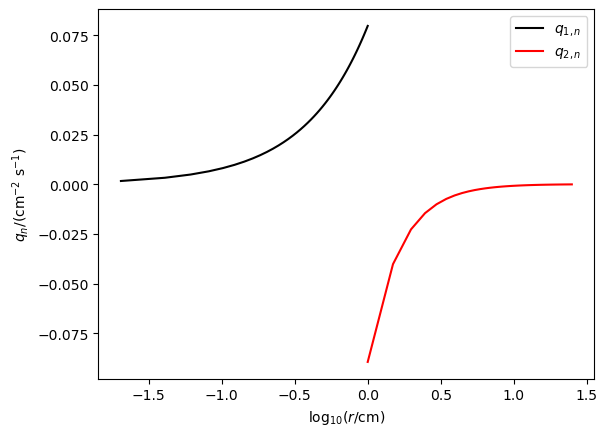

In [10]:
'''Plotting'''
import matplotlib.pyplot as plt

r_range_1 = np.linspace(r_0, r_R)[1:]
r_range_2 = np.linspace(r_R, r_oo)

plt.subplots()
plt.errorbar(x = np.log10(r_range_1/unit.cm), y = q_1(r_range_1)/(unit.cm**-2 * unit.second**-1), label = r'$q_{1,n}$',
            color = 'k')
plt.errorbar(x = np.log10(r_range_2/unit.cm), y = q_2(r_range_2)/(unit.cm**-2 * unit.second**-1), label = r'$q_{2,n}$',
            color = 'r')
plt.xlabel(r'$\mathrm{log}_{10}(r/\mathrm{cm})$')
plt.ylabel(r'$q_n/(\mathrm{cm^{-2}~s^{-1}})$')
plt.legend()

[2, 3, 4]

## [Galerkin Method w/ Finite Element Basis Functions](#toc)<a id="p3"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([0,R_\infty]\bigr)$ so that 

\begin{align*}
\bigl(-D\, u',v'\bigr) - \bigl(\Sigma_a\,u,v\bigr) + \bigl(s_0,v\bigr) + q_n(R_\infty)\,v(R_\infty)\,R^2_\infty &= 0 \quad\quad \forall \quad\quad v \in H^1\!\bigl([0,R_\infty]\bigr), 
\end{align*}

where $H^1\!\bigl([0,R_\infty]\bigr) := \bigl\{ u:[0,R_\infty]\subset\Reals\rightarrow \Reals \mid \bigl(u',u'\bigr) + \bigl(u,u\bigr) < \infty\bigr\}$. Because $u$ and $v$ belong to the same space of functions, this variational form is called the Galerkin's variational form. Choosing a finite dimensional subspace of $H^1\!\bigl([0,R_\infty]\bigr)$, say $V_N([0,R_\infty]) := \bigl\{ u_N = \sum\limits_{i=1}^N\,c_i\,\phi_i \bigr\} \subset H^1\!\bigl([0,R_\infty]\bigr)$, where $\{\phi_i\mid i=1\ldots,N\}$ is a basis of $V_N(0,R_\infty)$, the coefficients $\cvec := \{c_i\mid i=1,\ldots,N\}$ can be computed by solving the linear system of algebraic equations

\begin{equation*}
 \overset{(N\times N)}{\Amtrx}\,\overset{(N\times 1)}{\cvec} = \overset{(N\times 1)}\bvec ,
\end{equation*}

where:
  + $A_{i,j} = (D\,\phi'_j,\phi'_i) + (\Sigma_a\,\phi_j,\phi_i) $
  + $b_i = (s_0,\phi_i) - q_{nR_\infty}\,\phi_i(R_\infty)\,R^2_\infty$
  
Note: this method is identical to the Rayleigh-Ritz method, therefore the approximate solution  $u_N = \sum\limits_{i=1}^N\,c_i\,\phi_i$ is a minimizer of a particular norm (*i.e.* the energy norm). In addition, in spherical coordinates, the inner products read

\begin{align*}
\bigl(-D\, u',v'\bigr) &= \int\limits_0^{R_\infty} D(r)\, u'(r)\,v'(r)\, r^2\,dr  \\
\bigl(\Sigma_a\,u,v\bigr) &= \int\limits_0^{R_\infty} \Sigma_a(r)\,u(r)\,v(r)\,r^2\,dr \\
\bigl(s_0,v\bigr) &= \int\limits_0^{R_\infty} s_0(r)\,v(r)\,r^2\,dr
\end{align*}

In [ ]:
'''Parameters and data'''
import math

# Source
diffusion_coeff_1 = 1.5*unit.cm
sigma_a_1 = 0.005/unit.cm
source_1_dot = 1/unit.second
volume = 4/3*math.pi*(r_R)**3
source_1 = source_1_dot/volume

# Right side material
diffusion_coeff_2 = 1.0*unit.cm
sigma_a_2 = 0.01/unit.cm
source_2 = 0./unit.cm**3/unit.second

# normal flux
q_noo = 0.0*unit.cm**2/unit.second

### [MOOSE Kernels](#toc)<a id="kernels"></a>

The following MOOSE kernels were implemented to solve the [weak form](#weakform):
1. Diffusion term: $D \nabla \Phi \cdot \nabla \phi$
 + [interface](./include/kernels/DiffusionTerm.h) and [implementation](./src/kernels/DiffusionTerm.C).

### [Setup](#toc)<a id="setup"></a>

#### [One-Group Energy](#toc)<a id="onegroupenergy"></a>

## [Results and Analysis](#toc)<a id="ranalysis"></a>

- Text...

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5330: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [1] V. F. de Almeida, [*Engy-5050: Nuclear Reactor Physics: Neutron Diffusion from a Point Source*](https://nbviewer.org/github/dpploy/engy-5050/blob/main/notebooks/03-diff-point-source.ipynb), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] author, [reference]()
- [4] author, [reference]()